In [1]:
#all_slow

# Tutorial: Fine-Tuning Sequence Classification on Text Files with IMDB
> Tuning a Sequence Classification model on the IMDB Dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer for sequence classification on a custom dataset in text files format.

By the end of this you should be able to:

1. Build a dataset with the `SequenceClassificationDatasets` class, and their DataLoaders
2. Build a `SequenceClassificationTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner` available function as well as with the `EasySequenceClassifier` class within AdaptNLP

## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

In [2]:
# !pip install git+https://github.com/muellerzr/nbdev git+https://github.com/novetta/adaptnlp@dev -U

In [3]:
#hide
from nbdev.showdoc import *

## Getting the Dataset

First we need a dataset. We will use the `fastai` library to download the full `IMDB` Movie Reviews dataset

In [4]:
from fastai.data.external import URLs, untar_data

`URLs` holds a namespace of many data endpoints, and `untar_data` is a function that can download and extract any data from a given URL.

Combining both, we can download the data:

In [5]:
data_path = untar_data(URLs.IMDB)

If we look at what was downloaded, we will find a `train` and `test` folder:

In [6]:
data_path.ls()

(#7) [Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_lm')]

In each are folders seperating each text file by class:

In [7]:
(data_path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/pos'),Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/labeledBow.feat')]

As a result, we can say the dataset follows the following format:

- `train`
  - `class_a`
    - `text1.txt`
    - `text2.txt`
    - ...
  - `class_b`
    - `text1.txt`
    - ...
- `test` (or `valid`)
  - `class_a`
    - `text1.txt`
    - ...
  - `class_b`
    - `text1.txt`
    - ...

> Note: In this instance, test and validation have very similar meanings. Both are the dataset which is used to calculate the metrics during training (such as accuracy or F1Score)

Now that we have the dataset, and we know the format it is in, let's pick a viable model to train with

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for sequence classification.

First we need to import the class and generate an instance of it:

In [8]:
from adaptnlp import HFModelHub, HF_TASKS

In [9]:
hub = HFModelHub()

Next we can search for a model:

In [10]:
models = hub.search_model_by_task(
    task=HF_TASKS.TEXT_CLASSIFICATION
)

Let's look at a few:

In [11]:
models[:10]

[Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification],
 Model Name: roberta-base-openai-detector, Tasks: [text-classification],
 Model Name: roberta-large-mnli, Tasks: [text-classification],
 Model Name: roberta-large-openai-detector, Tasks: [text-classification]]

These are models specifically tagged with the `text-classification` tag, so you may not see a few models you would expect such as `bert_base_cased`.

We'll use that first model, `distilbert-base-uncased`:

In [12]:
model = models[0]

In [13]:
model

Model Name: distilbert-base-uncased-finetuned-sst-2-english, Tasks: [text-classification]

Now that we have picked a model, let's use the data API to prepare our data

> Note: It should be mentioned that this is optional, you can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets` with `SequenceClassificationDatasets`

Each task has a high-level data wrapper around the `TaskDatasets` class. In our case this is the `SequenceClassificationDatasets` class:

In [14]:
from adaptnlp import SequenceClassificationDatasets

There are multiple different constructors for the `SequenceClassificationDatasets` class, and you should never call the main constructor directly.

We will be using `from_folders` method:

In [15]:
show_doc(SequenceClassificationDatasets.from_folders)

<h4 id="SequenceClassificationDatasets.from_folders" class="doc_header"><code>SequenceClassificationDatasets.from_folders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L150" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationDatasets.from_folders</code>(**`train_path`**:`Path`, **`get_label`**:`callable`, **`tokenizer_name`**:`str`, **`tokenize`**:`bool`=*`True`*, **`is_multicategory`**:`bool`=*`False`*, **`label_delim`**=*`'_'`*, **`valid_path`**:`Path`=*`None`*, **`split_func`**=*`None`*, **`split_pct`**=*`0.2`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*)

Builds [`SequenceClassificationDatasets`](/adaptnlp/training.sequence_classification.html#SequenceClassificationDatasets) from a folder or groups of folders

**Function Arguments**:
* `train_path` (`Path`): The path to the training data
* `get_label` (`callable`): A function which grabs the label(s) given a text files `Path`
* `tokenizer_name` (`str`): The name of the tokenizer
* `tokenize` (`bool`): Whether to tokenize immediatly
* `is_multicategory` (`bool`): Whether each item has a single label or multiple labels
* `label_delim`: if `is_multicategory`, how to seperate the labels
* `valid_path` (`Path`): The path to the validation data
* `split_func`: Optionally a splitting function similar to RandomSplitter
* `split_pct`: What % to split the items in the `train_path`
* `tokenize_kwargs` (`dict`): kwargs for the tokenize function
* `auto_kwargs` (`dict`): kwargs for the AutoTokenizer.from_pretrained constructor


Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

In our case we have a `train_path` and `valid_path`, and the last thing we need to do is write a way to get the label from an individual file. 

Let's look at what one of these look like:

In [16]:
item = (data_path/'train'/'pos').ls()[0]

In [17]:
item

Path('/root/.fastai/data/imdb/train/pos/3205_8.txt')

So the label is located in the _name_ of the **parent** relative to the actual file:

In [18]:
item.parent.name

'pos'

Let's write a quick function to extract that:

> Note: The items get passed in as string file locations, so we should convert them to a Path to utilize the `.parent.name` functionality

In [19]:
from pathlib import Path

def get_y(item:str): return Path(item).parent.name

Next we'll build our `SequenceClassificationDatasets`:

In [20]:
dsets = SequenceClassificationDatasets.from_folders(
    data_path/'train',
    get_label=get_y,
    valid_path=data_path/'test',
    tokenizer_name=model.name,
    tokenize=True,
    split_func=get_y,
    tokenize_kwargs={'max_length':128, 'truncation':True, 'padding':True}
)

Using custom data configuration default-1f2b71eec4880b46
Reusing dataset text_no_new_line (/root/.cache/huggingface/datasets/text_no_new_line/default-1f2b71eec4880b46/0.0.0)
Using custom data configuration default-04d8fbd2bd2108a0
Reusing dataset text_no_new_line (/root/.cache/huggingface/datasets/text_no_new_line/default-04d8fbd2bd2108a0/0.0.0)
Loading cached processed dataset at /root/.cache/huggingface/datasets/text_no_new_line/default-1f2b71eec4880b46/0.0.0/cache-109f586a7b1ac79b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/text_no_new_line/default-04d8fbd2bd2108a0/0.0.0/cache-921d1183829bb9ec.arrow


> Note: If you only have a training folder, just pass in a `split_func` or `split_pct` to either have it split the dataset in a custom way, or pass in a percentage to randomly split by

And finally turn it into some `AdaptiveDataLoaders`.

These are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [21]:
show_doc(dsets.dataloaders)

<h4 id="SequenceClassificationDatasets.dataloaders" class="doc_header"><code>SequenceClassificationDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L208" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationDatasets.dataloaders</code>(**`batch_size`**=*`8`*, **`shuffle_train`**=*`True`*, **`collate_fn`**=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Build DataLoaders from `self`

**Function Arguments**:
* `batch_size`: A batch size
* `shuffle_train`: Whether to shuffle the training dataset


In [22]:
dls = dsets.dataloaders(batch_size=8)

Finally, let's view a batch of data with the `show_batch` function:

In [23]:
dls.show_batch()

,Input,Label
0,"the us state dept. would not like us to see this movie, because they have a beef with the iranian govt. however, it shows us just how civilized iran really is, despite the content of the film, which centers on the struggle of women there for equal rights in the simplest of terms : the ability to watch a soccer game at the stadium, which is strictly limited to male audiences alone. the film is hilariously funny, and in and of itself is proof of freedom of speech and expression in iran. i enjoyed this movie intensely. five girls try to penetrate the police border at the ticket gates to a soccer match between",pos
1,"awful! absolutely awful! no plot, no point, no end. it looks like the director turned the camera on and then the whole crew went to lunch. every day. i'm trying to give this video away but no one will take it. i'm giving it a 2 instead of a 1 because i like benigni. roger, i'm going to have to say thumbs down on this one. < br / > < br / >",neg
2,"at the time, "" my left foot "" was the little movie that could. it was hugely popular, and everyone applauded the fact that such a small, independent film could make it all the way to the oscars. < br / > < br / > since then, movies like "" my left foot "" are a dime a dozen, so it might be hard in retrospect to understand what all the fuss was about. it's certainly a well made and competent film, but it's clear that the bulk of its success rests on the shoulders of daniel day - lewis, who immerses himself in",pos
3,"i decided to watch this serial after seeing the endless adverts for it on the bbc in the weeks prior to it starting. i watched it despite the fact that i don't like the pretentious kind of stuff that alan hollinghurst writes ( sorry to his fans but i think we have a case of the emperor's new clothes with this author's work ). i admit that the acting is excellent, it is beautifully shot and i was reasonably entertained by it - however - i found that the storyline was extremely thin and after watching all three episodes feel very unsatisfied with this rather empty production.",neg
4,"i have a high tolerance for the weird, but frankly some movies go way, way beyond weird - - so far that they make your brain hurt. this is such a film. trying to understand it or even explain it is impossible and i think the film is best understood while taking drugs - - it's that incomprehensible. < br / > < br / > the film begins with some very cute japanese animation involving a cat. however, out of the blue, tons of twisted and occasionally disturbing things occur - - making me wonder if i am losing something in the translation. however, even if this is so",neg


## Building `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `SequenceClassificationTuner` and view it's documentation

In [24]:
from adaptnlp import SequenceClassificationTuner

In [25]:
show_doc(SequenceClassificationTuner)

<h2 id="SequenceClassificationTuner" class="doc_header"><code>class</code> <code>SequenceClassificationTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L222" class="source_link" style="float:right">[source]</a></h2>

> <code>SequenceClassificationTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**:`str`, **`tokenizer`**=*`None`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**=*`[<function accuracy at 0x7f27ea6cb0d0>, <fastai.metrics.AccumMetric object at 0x7f27ea4dd3a0>]`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **`num_classes`**:`int`=*`None`*, **\*\*`kwargs`**) :: [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner)

An [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner) with good defaults for Sequence Classification tasks

**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Function Arguments**:
* `dls` (`DataLoaders`): A set of DataLoaders
* `model_name` (`str`): A HuggingFace model
* `num_classes` (`int`): The number of classes
* `**kwargs`: kwargs for `Learner.__init__`


Next we'll pass in our `DataLoaders` and the name of our model:

> Note: If you are **not** using the data API and generating `AdaptiveDataLoaders`, you need to pass in the tokenizer to the constructor as well with `tokenizer=tokenizer`

In [33]:
tuner = SequenceClassificationTuner(dls, model.name)

By default we can see that it used `CrossEntropyLoss` as our loss function, and both `accuracy` and `F1Score` as our metrics:

In [34]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [35]:
_ = [print(m.name) for m in tuner.metrics]

accuracy
f1_score


Finally we just need to train our model!

## Fine-Tuning

To fine-tune, AdaptNLP's tuner class provides only a few functions to work with. The important ones are the `tune` and `lr_find` class.

As the `Tuner` uses `fastai` under the hood, `lr_find` calls fastai's Learning Rate Finder to help us pick a learning rate. Let's do that now:

In [36]:
show_doc(tuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L380" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`



/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003981071640737355)

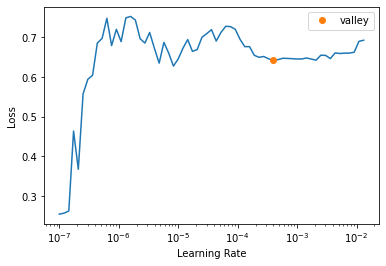

In [37]:
tuner.lr_find()

It recommends a learning rate of around 1e-4, so we will use that.

In [38]:
lr = 1e-4

Let's look at the documentation for `tune` function:

In [39]:
show_doc(tuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L366" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`



We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle
- CosineAnnealing
- SGDR

In [40]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy.

Let's now `tune` with our strategy and our newly found learning rate for three iterations over the dataset

In [41]:
tuner.tune(
    epochs=3, 
    lr=lr, 
    strategy=Strategy.OneCycle
)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.353429,0.367736,0.834720,0.826503,06:58
1,0.284561,0.348747,0.853640,0.849727,06:58
2,0.105604,0.388459,0.862440,0.862621,06:58


## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [42]:
show_doc(tuner.save)

<h4 id="AdaptiveTuner.save" class="doc_header"><code>AdaptiveTuner.save</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L388" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.save</code>(**`save_directory`**)

Save a pretrained model to a `save_directory`

**Function Arguments**:
* `save_directory`: A folder to save our model to


In [43]:
tuner.save('good_model')

'good_model'

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's infernece API, which we will show afterwards

## In Tuner

First let's write a sentence ot test with

In [44]:
sentence = "This movie was horrible! Hugh Jackman is a terrible actor"

And then predict with it:

In [45]:
show_doc(tuner.predict)

<h4 id="SequenceClassificationTuner.predict" class="doc_header"><code>SequenceClassificationTuner.predict</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/sequence_classification.py#L272" class="source_link" style="float:right">[source]</a></h4>

> <code>SequenceClassificationTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`detail_level`**:`DetailLevel`=*`'low'`*)

Predict some `text` for sequence classification with the currently loaded model

**Function Arguments**:
* `text` (`Union[List[str], str]`): Some text or list of texts to do inference with
* `bs` (`int`): A batch size to use for multiple texts
* `detail_level` (`DetailLevel `): A detail level to return on the predictions


In [46]:
tuner.predict(sentence)

{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['neg'],
 'probs': tensor([[9.9931e-01, 6.9142e-04]])}

### With the Inference API

Next we will use the `EasySequenceClassifier` class, which AdaptNLP offers:

In [47]:
from adaptnlp import EasySequenceClassifier

We simply construct the class:

In [48]:
classifier = EasySequenceClassifier()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes:

In [49]:
classifier.tag_text(
    sentence,
    model_name_or_path='good_model',
    class_names=['negative', 'positive']
)

2021-08-02 18:10:15,999 loading file good_model


{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['negative'],
 'probs': tensor([[9.9931e-01, 6.9142e-04]])}

And we got the exact same output and probabilities!

There are also different levels of predictions we can return (which is also the same with our earlier `predict` call).

These live in a namespace `DetailLevel` class, with a few examples below:

In [50]:
from adaptnlp import DetailLevel

In [51]:
DetailLevel.Low

'low'

While some Easy modules will not return different items at each level, most will return only a few specific outputs at the Low level, and everything possible at the High level:

In [52]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Low
)

{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['NEGATIVE'],
 'probs': tensor([[9.9931e-01, 6.9142e-04]])}

In [53]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.Medium
)

{'sentences': ['This movie was horrible! Hugh Jackman is a terrible actor'],
 'predictions': ['NEGATIVE'],
 'probs': tensor([[9.9931e-01, 6.9142e-04]]),
 'pairings': OrderedDict([('This movie was horrible! Hugh Jackman is a terrible actor',
               tensor([9.9931e-01, 6.9142e-04]))]),
 'classes': ['NEGATIVE', 'POSITIVE']}

In [54]:
classifier.tag_text(
    sentence,
    model_name_or_path = 'good_model',
    detail_level=DetailLevel.High
)

{'sentences': [Sentence: "This movie was horrible ! Hugh Jackman is a terrible actor"   [− Tokens: 11  − Sentence-Labels: {'sc': [NEGATIVE (0.9993), POSITIVE (0.0007)]}]],
 'predictions': ['NEGATIVE'],
 'probs': tensor([[9.9931e-01, 6.9142e-04]]),
 'pairings': OrderedDict([('This movie was horrible! Hugh Jackman is a terrible actor',
               tensor([9.9931e-01, 6.9142e-04]))]),
 'classes': ['NEGATIVE', 'POSITIVE']}